### Content Analysis Community Pages - HealthCare Posts
### Topic Modeling 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [3]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [4]:

#path = "Latinx2020/"
posts = pd.read_csv("community/FB_groups_States_health_care.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

/home/claudia/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (8,29,34,35) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(26732, 39)

In [5]:

posts.shape

(26732, 39)

In [6]:
posts['URL']

0        https://www.facebook.com/groups/79341620735648...
1        https://www.facebook.com/groups/79341620735648...
2        https://www.facebook.com/groups/79341620735648...
3        https://www.facebook.com/groups/79341620735648...
4        https://www.facebook.com/groups/79341620735648...
                               ...                        
26727    https://www.facebook.com/solsandiego/posts/380...
26728    https://www.facebook.com/solsandiego/posts/379...
26729    https://www.facebook.com/solsandiego/posts/391...
26730    https://www.facebook.com/solsandiego/posts/387...
26731    https://www.facebook.com/solsandiego/posts/382...
Name: URL, Length: 26732, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [7]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [8]:
posts.columns

Index(['Unnamed: 0', 'name', 'Page or Account URL', 'List', 'State', 'state',
       'Facebook Id', 'Group Name', 'User Name', 'Likes at Posting', 'Created',
       'Type', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Total Interactions',
       'Overperforming Score', 'MessageDescr', 'MessageOnly'],
      dtype='object')

In [9]:
posts["Created"].head(5)

0    2020-08-21 10:31:05 EDT
1    2020-08-22 11:12:40 EDT
2    2020-08-21 17:41:58 EDT
3    2020-08-19 18:33:44 EDT
4    2020-08-19 10:22:08 EDT
Name: Created, dtype: object

In [10]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0       2020-08-21 10:31:05-04:00
1       2020-08-22 11:12:40-04:00
2       2020-08-21 17:41:58-04:00
3       2020-08-19 18:33:44-04:00
4       2020-08-19 10:22:08-04:00
                   ...           
26727   2020-08-21 15:40:04-04:00
26728   2020-08-19 12:04:48-04:00
26729   2020-09-25 13:07:35-04:00
26730   2020-09-11 11:54:13-04:00
26731   2020-08-26 11:25:39-04:00
Name: converted_date, Length: 26732, dtype: datetime64[ns, tzlocal()]

In [11]:
posts['converted_date']=posts['converted_date'].dt.date

In [12]:
import seaborn as sns
pd.set_option('display.max_rows', None)
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date


converted_date  count
0      2020-08-18    363
1      2020-08-19    368
2      2020-08-20    319
3      2020-08-21    351
4      2020-08-22    258
5      2020-08-23    166
6      2020-08-24    391
7      2020-08-25    335
8      2020-08-26    385
9      2020-08-27    333
10     2020-08-28    345
11     2020-08-29    262
12     2020-08-30    160
13     2020-08-31    325
14     2020-09-01    377
15     2020-09-02    392
16     2020-09-03    342
17     2020-09-04    373
18     2020-09-05    243
19     2020-09-06    197
20     2020-09-07    369
21     2020-09-08    373
22     2020-09-09    388
23     2020-09-10    392
24     2020-09-11    394
25     2020-09-12    265
26     2020-09-13    197
27     2020-09-14    419
28     2020-09-15    426
29     2020-09-16    387
30     2020-09-17    382
31     2020-09-18    357
32     2020-09-19    202
33     2020-09-20    185
34     2020-09-21    404
35     2020-09-22    368
36     2020-09-23    414
37     2020-09-24    414
38     2020-09-25    322
39     2020-09-26    233
40     2020-09-27    209
41     2020-09-28    348
42     2020-09-29    402
43     2020-09-30    386
44     2020-10-01    409
45     2020-10-02    399
46     2020-10-03    227
47     2020-10-04    258
48     2020-10-05    431
49     2020-10-06    426
50     2020-10-07    379
51     2020-10-08    375
52     2020-10-09    341
53     2020-10-10    273
54     2020-10-11    215
55     2020-10-12    368
56     2020-10-13    452
57     2020-10-14    473
58     2020-10-15    361
59     2020-10-16    413
60     2020-10-17    224
61     2020-10-18    215
62     2020-10-19    422
63     2020-10-20    401
64     2020-10-21    424
65     2020-10-22    446
66     2020-10-23    360
67     2020-10-24    237
68     2020-10-25    185
69     2020-10-26    440
70     2020-10-27    456
71     2020-10-28    467
72     2020-10-29    477
73     2020-10-30    339
74     2020-10-31    277
75     2020-11-01    272
76     2020-11-02    370
77     2020-11-03    399

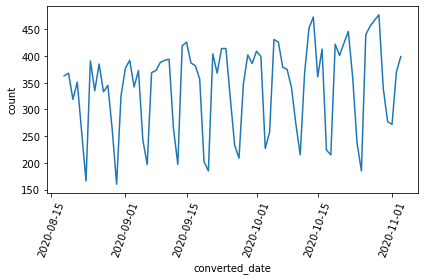

In [13]:
sns.lineplot(data=group_date, x='converted_date', y='count')
plt.xticks(rotation=70)
plt.tight_layout()

In [14]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

Unnamed: 0                                   name  \
23        1640  Hispanos unidos en New York (H.U.N.Y)   

                                Page or Account URL                   List  \
23  https://www.facebook.com/groups/793416207356486  Latinos+EstadosGroups   

       State     state      Facebook Id  \
23  New York  New York  793416207356486   

                               Group Name User Name  Likes at Posting  ...  \
23  Hispanos unidos en New York (H.U.N.Y)       NaN            6289.0  ...   

                                           Image Text         Link Text  \
23  'Covid-19 made in Wuhan lab controlled by Chin...  Primera Línea NY   

                                          Description  Sponsor Id  \
23  IMPACTANTE. Coronavirus fue fabricado  en un l...         NaN   

    Sponsor Name  Total Interactions  Overperforming Score  \
23           NaN                   0                 -66.0   

                                         MessageDescr  \
23  https://www.facebook.com/102726128134068/posts...   

                                          MessageOnly  converted_date  
23  https://www.facebook.com/102726128134068/posts...      2020-09-14  

[1 rows x 40 columns]

In [15]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [16]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [17]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

##  Count posts in general by state

In [18]:

df_count = posts.groupby(['State']).agg({'Facebook Id':'count'}).reset_index() 

df_count.columns = ['State','Posts_Counts']
df_count.sort_values(by=['State'], ascending=True,inplace=True)
df_count.fillna(0, inplace=True)
df_count['Posts_Counts'] = df_count['Posts_Counts'].astype(int)
df_count.head(10)



State  Posts_Counts
0      Arizona            53
1   California          1039
2     Colorado            56
3  Connecticut           152
4      Florida          9339
5      Georgia          1052
6     Illinois           289
7      Indiana             2
8         Iowa            15
9     Maryland           856

In [19]:
#us_states['State'] = us_states['State']
from functools import reduce
data_frames = [df_count, us_states]
missing_states  = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
missing_states.fillna(0, inplace=True)
missing_states['Posts_Counts'] = missing_states['Posts_Counts'].astype(int)
#missing_states

## 3. Which groups are publishing the majority of the content

In [20]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

Facebook Id
Group Name                                                     
LATINOS EN NEW YORK                                        1867
Venezolanos en Miami                                       1084
Latinos en New Jersey y areas cercanas                      541
Cubanos en miamifl                                          516
Venezolanos en La Florida                                   469
Latinos en Tampa Bay official                               463
Venezolanos en Houston Tx                                   452
Latinos en Florida Broward & Miami Dade                     422
Venezolanos En Orlando                                      419
Marketing  Latinos en Atlanta  ( USA )                      408
Ecuatorianos en La Florida                                  388
Latinos en New Jersey (NJ) y New York (NY)                  379
latinos en New York                                         352
Venezolanos En Tampa Bay Oficial                            351
Mexicanos unidos de utah                                    350
Venezolanos en Orlando                                      340
Boricuas en Orlando VIP                                     324
Peruanos en DC Maryland & Virginia (DMV)                    317
Grupo de Venezolanos Activos en Georgia                     313
Venezolanos en Florida.                                     310
Latinos en Orlando Florida                                  305
Latinos en Texas                                            277
Venezolanos en north carolina (ventas)                      275
latinos en maryland  washington dc y virginia               259
Venezolanos viviendo en Miami                               234
Latinos en los Angeles California compra y venta            218
Ciudadanos Venezolanos en Atlanta.                          208
Ecuatorianos en Orlando                                     205
Venezolanos en Kissimmee                                    203
 Latinos en Miami                                           195
Latinos en Charlotte North Carolina                         189
Hispanos en Columbus Ohio                                   189
Mexicanos en Texas                                          188
Colombianos Venezolanos Mexicanos Latinos en Katy           186
Boricuas en Dallas Y Fort Worth                             182
TRABAJOS PARA LATINOS - HOUSTON                             178
Hispanos en West Palm Beach FL                              174
BORICUAS EN KISSIMMEE Y ORLANDO                             172
Ticos en New Jersey                                         172
Venezolanos en Utah                                         166
Venezolanos en Nashville                                    162
Peruanos en New Jersey                                      153
Argentinos en Miami                                         153
Nicas Unidos En Miami                                       141
Venezolanos en Charlotte NC                                 138
LA CHACHARA LATINA TEXAS                                    137
Mexicanos en California                                     134
Latinos en SALT LAKE CITY                                   130
Peruanos Unidos en DC Maryland & Virginia                   128
CUBANOS Y LATINOS RESIDENTES EN MIAMI BEACH. FL...          124
Latinos Unidos En South Carolina                            123
Mexicanos En North Carolina                                 120
Latinos en Minnesota                                        120
CUBANOS EN HOUSTON tx                                       118
CUBANOS EN HOUSTON                                          112
Peruanos en Orlando Fl                                      111
SALVADOREOS EN HOUSTON                                      111
CUBANOS EN ORLANDOFLORIDA                                   111
Boricuas en San AntonioTX                                   109
SAN BERNARDINO SWAPMEET LATINO                              108
venezolanos En Austin                                       108
Cubans and Hispanics

## Tokenize words and Clean-up text

In [21]:
content = posts.copy()
content.drop_duplicates(subset= ['MessageDescr'], inplace=True)
content['MessageDescr']

0        Join us in collaboration with NYS Senator Zell...
1        https://twitter.com/Primera_NY/status/12971887...
2        Una información de gran interés para las madre...
3        Get tested for COVID-19 today at any of the te...
4         Muy buenos días... ☕️ un delicioso café salud...
5         Gracias a mi líder y un gran ser humano, por ...
6         Mary Kay clear proof...\nSoluciones para el a...
7         LA CITA CON EL DOCTOR \n\nHoy el Dr. nos dice...
8        Join us in collaboration with Zellnor Myrie 米维...
9        🚨Quierés bajar de peso🔥Quierés mejorar tu salu...
10        Por Javier Castaño Desde este martes primero ...
11       Mejora la salud de tu cabello.. Seytu cosmétic...
12        💥 Nuevo Mes! Nuevas Metas!! 💥 \nListos para i...
13        Ahora los cinco condados de Nueva York tienen...
14        Gracias hermosas y no se olviden compartir!!\...
15       NO MAS EXCUSAS🗣️🗣️ comienza a tener resultados...
16       💫Te gustaría realizar cambios en tu físico💪 y .

In [22]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(16839,)

In [23]:
# Convert to list
data = content.cleanMessage.tolist()

In [24]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [25]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['join', 'us', 'in', 'collaboration', 'with', 'nys', 'senator', 'zellnor', 'myrie', '米维s', 'councilman', 'carlos', 'menchaca', 'campaign', 'against', 'hunger', 'for', 'food', 'and', 'mask', 'distribution', 'pop', 'up', 'we', 'will', 'also', 'be', 'there', 'to', 'assist', 'you', 'with', 'completing', 'your', 'census', 'this', 'event', 'will', 'take', 'place', 'on', 'saturday', 'august', 'nd', 'by', 'appointment', 'only', 'this', 'event', 'will', 'be', 'held', 'at', 'modern', 'eyes', 'optical', 'th', 'th', 'ave', 'brooklyn', 'ny', 'for', 'more', 'information', 'call', 'us', 'at', 'or', 'email', 'info', 'amphsonline', 'org', 'to', 'make', 'an', 'appointment', 'register', 'at', 'bit', 'ly', 'amphsfood', 'or', 'call', 'us', 'at', 'acompanenos', 'en', 'colaboracion', 'con', 'el', 'senador', 'del', 'estado', 'de', 'nueva', 'york', 'zellnor', 'myrie', 'el', 'concejal', 'carlos', 'menchaca', 'la', 'campana', 'contra', 'hambre', 'para', 'una', 'distribucion', 'de', 'alimentos', 'mascaras', 'tam

#### Creating Bigram and Trigram Models

In [26]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['join_us', 'in_collaboration_with', 'nys', 'senator', 'zellnor_myrie', '米维s', 'councilman', 'carlos_menchaca', 'campaign', 'against', 'hunger', 'for', 'food', 'and', 'mask', 'distribution', 'pop_up', 'we', 'will', 'also', 'be', 'there', 'to', 'assist', 'you', 'with', 'completing', 'your', 'census', 'this', 'event', 'will_take_place', 'on', 'saturday', 'august', 'nd', 'by', 'appointment', 'only', 'this', 'event', 'will_be_held', 'at', 'modern', 'eyes', 'optical', 'th', 'th', 'ave', 'brooklyn_ny', 'for_more_information', 'call_us', 'at', 'or', 'email_info', 'amphsonline_org', 'to', 'make_an_appointment', 'register', 'at', 'bit_ly', 'amphsfood', 'or', 'call_us', 'at', 'acompanenos', 'en', 'colaboracion', 'con', 'el', 'senador', 'del', 'estado', 'de', 'nueva_york', 'zellnor_myrie', 'el', 'concejal_carlos_menchaca', 'la', 'campana', 'contra', 'hambre', 'para', 'una', 'distribucion', 'de', 'alimentos', 'mascaras', 'tambien', 'estaremos', 'alli', 'para', 'ayudarle', 'completar', 'su', 'censo

## Remove Stopwords, Make Bigrams and Lemmatize

In [27]:
#import nltk
#nltk.download('stopwords')
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [28]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [29]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
#!python3 -m spacy download es_core_news_sm
#!python3 -m spacy download en
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [30]:
data_lemmatized[0]

['senator',
 'also',
 'august',
 'optical',
 'ave',
 'senador',
 'concejal_carlos',
 'menchaca',
 'campana',
 'hambre',
 'alimento',
 'mascar',
 'tambien',
 'alli',
 'ayudarle',
 'completar',
 'censar',
 'evento',
 'sabado',
 'agostar',
 'solo',
 'sito',
 'evento',
 'optical',
 'ave',
 'envie',
 'correo_electronico',
 'info',
 'hacer',
 'sito',
 'registrarse',
 'aqui',
 '议员carlos',
 '我们将提供食物并协助您完成',
 '年人口普查',
 'photos',
 'academy',
 'public',
 'services_amphs']

In [31]:
print(data_words_nostops[1:2])

[[]]


## Bag of Words

In [32]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [33]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [34]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [35]:
final_dict.most_common(1000)

[('salud', 8715),
 ('seguro', 4933),
 ('vida', 2544),
 ('hacer', 2541),
 ('personar', 2537),
 ('poder', 2345),
 ('ayudar', 2278),
 ('solo', 2107),
 ('trabajar', 2059),
 ('medicar', 2050),
 ('mejor', 1939),
 ('hoy', 1918),
 ('ano', 1755),
 ('querer', 1728),
 ('familia', 1684),
 ('mejorar', 1589),
 ('producto', 1431),
 ('nuevo', 1398),
 ('necesitar', 1378),
 ('casar', 1350),
 ('cuidar', 1321),
 ('tambien', 1279),
 ('tener', 1271),
 ('tiempo', 1269),
 ('servicio', 1230),
 ('decir', 1214),
 ('dinero', 1193),
 ('plan', 1089),
 ('llamar', 1060),
 ('beneficio', 1049),
 ('bueno', 1034),
 ('ahora', 1033),
 ('partir', 1018),
 ('conocer', 1010),
 ('covid / coronavirus', 1010),
 ('saber', 980),
 ('dar', 979),
 ('ofrecer', 976),
 ('momento', 972),
 ('esperar', 946),
 ('problema', 944),
 ('cambiar', 932),
 ('importante', 923),
 ('contar', 914),
 ('oportunidad', 900),
 ('cobertura', 882),
 ('usar', 876),
 ('vivir', 870),
 ('siempre', 853),
 ('pedir', 834),
 ('compartir', 823),
 ('buscar', 807),
 ('ph

In [67]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [68]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
#print(bow_df)

In [69]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [70]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

idf_weights
salud                               1.861271
seguro                              2.719826
vida                                3.233751
hacer                               3.283178
personar                            3.287849
ayudar                              3.305559
poder                               3.318748
solo                                3.330281
medicar                             3.336405
mejor                               3.352504
hoy                                 3.360652
trabajar                            3.417625
familia                             3.487999
querer                              3.503124
mejorar                             3.528851
ano                                 3.613496
necesitar                           3.647286
casar                               3.746796
nuevo                               3.751436
cuidar                              3.760782
tambien                             3.801018
tiempo                              3.801996
tener                               3.805917
producto                            3.811828
servicio                            3.865621
dinero                              3.939168
ahora                               3.941415
conocer                             3.942541
llamar                              3.944795
plan                                3.958432
beneficio                           3.971098
esperar                             3.979242
momento                             4.002884
bueno                               4.012499
dar                                 4.014918
importante                          4.027098
partir                              4.029552
ofrecer                             4.033244
saber                               4.036950
photos                              4.063284
contar                              4.070937
cambiar                             4.112773
buscar                              4.133003
oportunidad                         4.149487
decir                               4.160629
problema                            4.167657
vivir                               4.169068
usar                                4.176155
compartir                           4.190482
cobertura                           4.197723
obtener                             4.218282
siempre                             4.224235
encontrar                           4.227224
perder                              4.240789
tipo                                4.253003
pedir                               4.290566
dejar                               4.292162
enfermedad                          4.295362
bien                                4.303407
pesar                               4.306643
mayor                               4.309890
asi                                 4.316415
gran                                4.316415
ver                                 4.319694
pasar                               4.322983
formar                              4.327938
tomar                               4.336251
dia                                 4.337922
mensaje                             4.339595
recibir                             4.344633
ir                                  4.353086
llegar                              4.375405
desear                              4.375405
pagar                               4.375405
resultar                            4.382373
necesidad                           4.396458
citar                               4.416154
preguntar                           4.432563
hora                                4.441797
coronavirus                         4.451116
medicos                             4.485406
manera                              4.508936
menos                               4.512912
doctor                              4.514906
recordar                            4.518906
auto                                4.518906
comenzar                            4.518906
personal                            4.524936
proteger                    

In [71]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [74]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False)

tfidf
sito                0.364503
optical             0.364503
ave                 0.303729
evento              0.210576
august              0.195769
我们将提供食物并协助您完成       0.187862
年人口普查               0.187862
menchaca            0.187862
议员carlos            0.177900
concejal_carlos     0.177900
senator             0.168734
services_amphs      0.166437
academy             0.152919
envie               0.151864
public              0.145011
mascar              0.140516
senador             0.137840
censar              0.137346
registrarse         0.136865
correo_electronico  0.136395
alli                0.131858
hambre              0.131858
ayudarle            0.130439
aqui                0.123347
campana             0.114360
info                0.113769
also                0.111311
agostar             0.110804
sabado              0.108452
completar           0.108341
alimento            0.101529
photos              0.079243
tambien             0.074128
solo                0.064948
hacer               0.064029

In [75]:
pd.set_option('display.max_colwidth',None)
#word = df.index[8]
word = r"\b(optical)\b"
content["lowercase"] = content['MessageOnly'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')

word_messages

/home/claudia/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


unique_messages  \
0  en un cambio de última hora a través de estados clave, el dhs y el ice están defendiendo la reelección de donald trump en las últimas semanas previas a las elecciones de 2020, el departamento de seguridad nacional y el servicio de inmigración y control de aduanas de ee. uu. lanzaron un bombardeo publicitario muy inusual para destacar las acciones de aplicación de la ley de inmigración en estados clave donde el presidente donald trump está detrás de su oponente joe biden en la centro. como parte de este impulso, los principales líderes del dhs y del ice han viajado por todo el país para celebrar al menos cuatro conferencias de prensa este mes en pensilvania, arizona y minnesota, siguiendo el camino de las manifestaciones de trump mientras hace un llamamiento de último minuto a los votantes allí. estos anuncios públicos de altos líderes antes de las elecciones, que exfuncionarios le dijeron a time que son anormales, si no sin precedentes, se han llevado a cabo para publicitar principalmente operaciones rutinarias de cumplimiento de la ley de inmigración que generalmente se habrían revelado con poca fanfarria. en cambio, los funcionarios del dhs y del ice los han utilizado como una plataforma para defender agresivamente las políticas de inmigración del presidente, a menudo adoptando un tono marcadamente trumpiano y haciéndose eco de partes de su discurso. en múltiples eventos, el secretario interino de seguridad nacional chad wolf y su adjunto ken cuccinelli han hablado sobre inmigrantes que toman trabajos estadounidenses, criticado las ciudades santuario dirigidas por demócratas, promocionado "américa primero" y advirtió sobre "personas malvadas que buscan viajar a los estados unidos con la intención de dañar y matar a los estadounidenses ". en phoenix, la semana pasada, wolf advirtió que habría un aumento en la migración y una "crisis de salud pública inimaginable" en la frontera sur si trump perdía las elecciones, una serie de declaraciones puramente políticas que sorprendieron a muchos ex funcionarios. "la retórica que salió de wolf y cuccinelli parece ser un brazo de propaganda de la casa blanca", dijo a time dave lapan, un coronel retirado del cuerpo de marines que se desempeñó como portavoz del dhs durante la administración trump bajo el entonces secretario john kelly. como resultado, dice, el dhs "no está siendo visto como una agencia de aplicación de la ley confiable, sino como una extensión de la campaña de reelección del presidente". los comentarios de wolf en phoenix en particular "realmente cruzaron una línea hacia la campaña electoral", dice lapan. el 21 de octubre, cuccinelli, el subsecretario interino del dhs, viajó a pittsburgh para anunciar el arresto de quince estudiantes extranjeros por presuntamente usar un programa de visa de trabajo para estudiantes para permanecer en los estados unidos de manera fraudulenta. aunque fue a pensilvania para hacer el anuncio, que normalmente habría justificado un simple comunicado de prensa, no el viaje de un funcionario superior, los arrestos se realizaron en florida, massachusetts, nueva jersey, texas, tennessee y washington dc, así como en ese estado. los arrestos fueron parte de la "operación optical illusion", una ofensiva contra el programa federal de entrenamiento táctico opcional, que permite a los estudiantes internacionales trabajar en su campo de estudio mientras tienen una visa de estudiante estadounidense. cuccinelli vinculó directamente esta acción de aplicación de la ley de inmigración a la agenda de trump, diciendo que los arrestos "abrirán esos puestos de trabajo para los trabajadores estadounidenses" y enfatizando que esto "ha sido una prioridad muy alta para este presidente". fue el último de una serie de movimientos publicitarios del dhs para amplificar el mensaje de inmigración de la campaña de trump en pensilvania, donde el presidente está detrás de biden por 6 puntos, según una encuesta reciente de usa today / suffolk university. la

### Repeated messages

In [43]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

#results.to_csv("mostpopularNewsMedia.csv")

In [44]:
##results.sort_values(by='Counts',ascending=False)

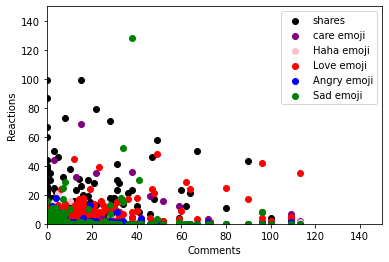

In [45]:
results.reset_index()
plt.xlim(0,150)
plt.ylim(0,150)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


## Topic Modeling
### Create the Dictionary and Corpus needed for Topic Modeling

In [46]:


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)]]


[[('academy', 1),
  ('agostar', 1),
  ('alimento', 1),
  ('alli', 1),
  ('also', 1),
  ('aqui', 1),
  ('august', 1),
  ('ave', 2),
  ('ayudarle', 1),
  ('campana', 1),
  ('censar', 1),
  ('completar', 1),
  ('concejal_carlos', 1),
  ('correo_electronico', 1),
  ('envie', 1),
  ('evento', 2),
  ('hacer', 1),
  ('hambre', 1),
  ('info', 1),
  ('mascar', 1),
  ('menchaca', 1),
  ('optical', 2),
  ('photos', 1),
  ('public', 1),
  ('registrarse', 1),
  ('sabado', 1),
  ('senador', 1),
  ('senator', 1),
  ('services_amphs', 1),
  ('sito', 2),
  ('solo', 1),
  ('tambien', 1),
  ('年人口普查', 1),
  ('我们将提供食物并协助您完成', 1),
  ('议员carlos', 1)]]

## Buiding the Topic Model

In [47]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [48]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.159*"necesitar" + 0.079*"grupo" + 0.061*"llegar" + 0.059*"iniciar" + '
  '0.059*"desear" + 0.053*"octubre" + 0.050*"available" + 0.041*"atender" + '
  '0.038*"serve" + 0.027*"paises"'),
 (1,
  '0.126*"invitar" + 0.116*"ademar" + 0.083*"participar" + 0.062*"privar" + '
  '0.059*"clinica" + 0.038*"pudrir" + 0.015*"testimonio" + 0.006*"patrocinar" '
  '+ 0.005*"sortear" + 0.003*"ala"'),
 (2,
  '0.059*"nuevo" + 0.049*"llamar" + 0.042*"programar" + 0.036*"enfermedad" + '
  '0.036*"publicar" + 0.032*"contar" + 0.030*"recurso" + 0.027*"septiembre" + '
  '0.027*"departamento" + 0.026*"citar"'),
 (3,
  '0.062*"photos" + 0.054*"partir" + 0.052*"ahora" + 0.047*"pagar" + '
  '0.042*"saber" + 0.041*"hora" + 0.036*"general" + 0.034*"menos" + '
  '0.034*"hispano" + 0.032*"deber"'),
 (4,
  '0.110*"latino" + 0.087*"espanol" + 0.071*"probar" + 0.064*"agostar" + '
  '0.060*"gratuito" + 0.051*"abrir" + 0.037*"mostrar" + 0.035*"listo" + '
  '0.034*"seminario" + 0.034*"info"'),
 (5,
  '0.262*"virt

## Compute Model Perplexity and Coherence Score

In [49]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -18.341695222347415

Coherence Score:  0.38297328778052503


## Visualize the topics-keywords

In [50]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.355020  0.282927       1        1  27.656321
10    -0.247683  0.031244       2        1  14.854200
2     -0.145334 -0.285438       3        1   7.965328
9     -0.107149 -0.125823       4        1   7.728559
19    -0.101089 -0.069441       5        1   7.418434
3     -0.111554 -0.138718       6        1   7.300307
12    -0.031036 -0.020898       7        1   3.745818
7      0.049837  0.017944       8        1   2.863774
0      0.062368  0.021374       9        1   2.750346
15     0.055864  0.019429      10        1   2.617000
14     0.046475  0.016739      11        1   2.492014
18     0.043185  0.016450      12        1   2.281677
16     0.097578  0.028896      13        1   1.948936
8      0.089314  0.027403      14        1   1.894891
4      0.070175  0.023366      15        1   1.582139
13     0.077851  0.025094      16        1   1.445593
17     0.113963  0.031239      17        1   1.193586
1      0.134412  0.033052      18        1   1.008624
5      0.120836  0.031986      19        1   0.745942
11     0.137009  0.033176      20        1   0.506514, topic_info=                              Term          Freq         Total Category  \
53                           salud  17283.000000  17283.000000  Default   
125                         seguro   7868.000000   7868.000000  Default   
16                           hacer   4475.000000   4475.000000  Default   
123                       personar   5880.000000   5880.000000  Default   
39                          cuidar   2186.000000   2186.000000  Default   
49                           poder   4164.000000   4164.000000  Default   
38                     coronavirus   2341.000000   2341.000000  Default   
144                       servicio   1805.000000   1805.000000  Default   
733                         mental   1897.000000   1897.000000  Default   
166                       producto   1738.000000   1738.000000  Default   
470                      necesitar   1919.000000   1919.000000  Default   
114                         querer   2446.000000   2446.000000  Default   
362                       trabajar   4777.000000   4777.000000  Default   
97                           decir   3113.000000   3113.000000  Default   
135                        conocer   1488.000000   1488.000000  Default   
116                          tener   2045.000000   2045.000000  Default   
140                          nuevo   2070.000000   2070.000000  Default   
383                          vivir   2008.000000   2008.000000  Default   
22                          photos   1969.000000   1969.000000  Default   
458                         ayudar   4065.000000   4065.000000  Default   
738                            ano   3981.000000   3981.000000  Default   
122                        ofrecer   1250.000000   1250.000000  Default   
379                           vida   3768.000000   3768.000000  Default   
64                             hoy   3746.000000   3746.000000  Default   
120                        medicar   3697.000000   3697.000000  Default   
31                         tambien   2427.000000   2427.000000  Default   
133                         buscar   1253.000000   1253.000000  Default   
1023                        partir   1726.000000   1726.000000  Default   
448                           usar   2377.000000   2377.000000  Default   
426                        mensaje   1233.000000   1233.000000  Default   
53                           salud  17281.691406  17283.451172   Topic1   
125                         seguro   7867.196289   7868.951660   Topic1   
362                       trabajar   4775.950195   4777.705566   Topic1   
458                         ayudar   4063.439941   4065.196533   Topic1   
738                            ano   3979.291260   3981.047852   Topic1   
379                           vida   3767.009521   3768.766113   Topi

## Building LDA Mallet Model

In [51]:
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [52]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
from gensim.models.wrappers import LdaMallet


In [53]:
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path

In [54]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [55]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('ninos', 0.029598864413017192),
   ('ano', 0.025498133641764367),
   ('doctor', 0.02507754587035382),
   ('hacer', 0.02476210504179591),
   ('necesitar', 0.023342621313285315),
   ('preguntar', 0.022448872299037907),
   ('cuidar', 0.02234372535618527),
   ('citar', 0.021660270227643132),
   ('usar', 0.019136743599179853),
   ('dolor', 0.018137847642079808)]),
 (7,
  [('salud', 0.12140202983750208),
   ('medicar', 0.054739060506904774),
   ('familia', 0.04115135045199934),
   ('ayudar', 0.0361599467583606),
   ('photos', 0.030447562531196272),
   ('perder', 0.025733459042759692),
   ('post', 0.02362597748322334),
   ('momento', 0.019910154733514502),
   ('pedir', 0.015639731573401365),
   ('casar', 0.014641450834673617)]),
 (13,
  [('necesitar', 0.03748253144340188),
   ('pagar', 0.036434418047514475),
   ('llamar', 0.031343581553204235),
   ('obtener', 0.02500499101617089),
   ('tener', 0.024955080854461967),
   ('servicio', 0.024256338590537035),
   ('disponible', 0.02280894

## Finding the optimal number of topics for LDA

In [56]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [57]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

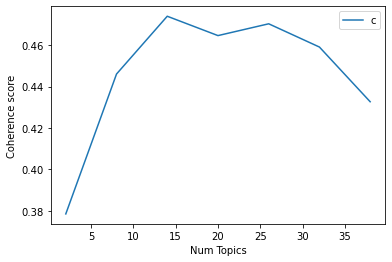

In [58]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [59]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3784
Num Topics = 8  has Coherence Value of 0.4461
Num Topics = 14  has Coherence Value of 0.474
Num Topics = 20  has Coherence Value of 0.4646
Num Topics = 26  has Coherence Value of 0.4704
Num Topics = 32  has Coherence Value of 0.4591
Num Topics = 38  has Coherence Value of 0.4327


In [60]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.144*"seguro" + 0.032*"plan" + 0.026*"cobertura" + 0.025*"medicar" + '
  '0.018*"auto" + 0.013*"periodo" + 0.013*"obtener" + 0.013*"asegurar" + '
  '0.013*"llamanos" + 0.012*"necesidad"'),
 (1,
  '0.028*"usar" + 0.027*"producto" + 0.019*"piel" + 0.018*"cuidar" + '
  '0.017*"aguar" + 0.015*"linear" + 0.013*"comprar" + 0.012*"belleza" + '
  '0.012*"resultar" + 0.011*"natural"'),
 (2,
  '0.047*"trabajar" + 0.023*"oportunidad" + 0.022*"producto" + 0.020*"buscar" '
  '+ 0.019*"ganar" + 0.019*"pagar" + 0.017*"negociar" + 0.016*"equipar" + '
  '0.015*"iniciar" + 0.014*"casar"'),
 (3,
  '0.035*"ano" + 0.015*"ninos" + 0.013*"hijo" + 0.010*"pasar" + 0.009*"doctor" '
  '+ 0.009*"hacer" + 0.008*"hombre" + 0.008*"llevar" + 0.007*"tan" + '
  '0.007*"decir"'),
 (4,
  '0.015*"coronavirus" + 0.013*"decir" + 0.012*"trump" + 0.010*"publicar" + '
  '0.010*"presidente" + 0.009*"caso" + 0.008*"virus" + 0.007*"venezolano" + '
  '0.007*"millón" + 0.007*"muerte"'),
 (5,
  '0.036*"nuevo" + 0.026*"hoy" 

## Finding the dominant topic in each sentence

In [61]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0            11.0              0.1504   
1            1             0.0              0.0714   
2            2             5.0              0.1159   
3            3            11.0              0.2508   
4            4            12.0              0.0975   
5            5             4.0              0.0944   
6            6             1.0              0.0847   
7            7            13.0              0.1426   
8            8            11.0              0.1555   
9            9            10.0              0.2092   

                                                                                     Keywords  \
0  servicio, ofrecer, partir, hacer, internacional, casar, tambien, recibir, dias, septiembre   
1     seguro, plan, cobertura, medicar, auto, periodo, obtener, asegurar, llamanos, necesidad   
2      nuevo, hoy, conocer, mental, tiempo, preguntar, importante, invitar, disponible, vivir   
3  servicio, ofrecer, partir, hacer, internacional, casar, tambien, recibir, dias, septiembre   
4       ayudar, saludable, cuerpo, problema, mejorar, reducir, aumentar, tomar, pesar, evitar   
5    coronavirus, decir, trump, publicar, presidente, caso, virus, venezolano, millón, muerte   
6            usar, producto, piel, cuidar, aguar, linear, comprar, belleza, resultar, natural   
7    medicar, tratamiento, enfermedad, mujer, llamar, citar, medicos, cancer, paciente, mayor   
8  servicio, ofrecer, partir, hacer, internacional, casar, tambien, recibir, dias, septiembre   
9                  salud, mejorar, mejor, cuidar, photos, querer, pesar, post, calidad, bajar   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Text  
0  Join us in collaboration with NYS Senator Zellnor Y. Myrie 米维s, Councilman Carlos Menchaca, Campaign Against Hunger for a food and mask distribution pop up! We will also be there to assist you with completing your 2020 Census. This event will take place on Saturday, August 22nd by appointment only This event will be held at Modern Eyes Optical, 5020th 8th ave, Brooklyn, NY 11220. For more information call us at (212) 256 9036 or email info@amphsonline.org. To make an appointment register at: bit.ly/amphsfood or call us at: (212) 256 9036 ¡Acompáñenos en colaboración con el senador del estado de Nueva York Zellnor Myrie, el concejal Carlos Menchaca, la Campaña Contra Hambre para una distribución de alimentos y máscaras! También estaremos allí para ayudarle a completar su Censo 2020. Este evento es el sábado 22 de agosto solo por sita . Este evento será en Modern Eyes Optical, 5020th 8th ave, Brooklyn, NY 11220. Para más 

## Find the most representative document for each topic

In [62]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

Topic_Num  Topic_Perc_Contrib  \
0         0.0              0.4675   
1         1.0              0.7317   
2         2.0              0.4458   
3         3.0              0.5492   
4         4.0              0.8087   
5         5.0              0.5398   
6         6.0              0.6397   
7         7.0              0.6515   
8         8.0              0.6190   
9         9.0              0.6953   
10       10.0              0.3348   
11       11.0              0.7050   
12       12.0              0.6283   
13       13.0              0.5505   

                                                                                      Keywords  \
0      seguro, plan, cobertura, medicar, auto, periodo, obtener, asegurar, llamanos, necesidad   
1             usar, producto, piel, cuidar, aguar, linear, comprar, belleza, resultar, natural   
2     trabajar, oportunidad, producto, buscar, ganar, pagar, negociar, equipar, iniciar, casar   
3                           ano, ninos, hijo, pasar, doctor, hacer, hombre, llevar, tan, decir   
4     coronavirus, decir, trump, publicar, presidente, caso, virus, venezolano, millón, muerte   
5       nuevo, hoy, conocer, mental, tiempo, preguntar, importante, invitar, disponible, vivir   
6                               hacer, dia, dar, siempre, querer, ir, bien, vivir, vida, decir   
7              salud, vida, familia, ayudar, necesitar, tener, cambiar, perder, saber, momento   
8              dinero, problema, consultar, trabajar, tipo, vida, futuro, amor, amarre, suerte   
9                     personar, poder, solo, hacer, ahora, compartir, hoy, esperar, tener, asi   
10                  salud, mejorar, mejor, cuidar, photos, querer, pesar, post, calidad, bajar   
11  servicio, ofrecer, partir, hacer, internacional, casar, tambien, recibir, dias, septiembre   
12       ayudar, saludable, cuerpo, problema, mejorar, reducir, aumentar, tomar, pesar, evitar   
13    medicar, tratamiento, enfermedad, mujer, llamar, citar, medicos, cancer, paciente, mayor   

                                                                                                                                                                                                                                                                                                                                                                                                               Text  
0   MI Tía Rita Elisa Ramírez vive en San Cristóbal, Venezuela. Una Anciana de 79 años, jubilada y soltera, no tiene hijos .Vive sola,en estos momentos esta postrada en su cama, inmovilizada, solo asistida por algunos parientes que le dan asistencia y cuidados. necesita realizarse una intervención quirúrgica para colocarle una prótesis de Thompson derecha por fractura de la cabeza del fémur. De El...  
1   ⚠️HOY A MITAD DE PRECIO🔊 🧏🏻‍♀️Colocas PESTAÑAS? REALIZAS CEJAS? ERES ESTÉTICISTA,💆🏻‍♀️👩🏻‍⚕️ COSMETOLOGA? 🎓 🛑ESTO TE PUEDE INTERESAR🛑 📢👉🏽Lo Mejor Para Ti 2 PORTAFOLIOS EN 1 👩‍💻Más De 350 😮 ARCHIVOS DIGITALES 🥇Contamos con RECOMENDACIONES. ( Mas de 15.000. Paginas) con la Siguiente Información 100% Actualizado En 💁🏻‍♀️ ESTÉTICA COSMATRIA NUTRICIÓN, ENFERMERIA CEJAS PESTAÑAS MICROBLADING Y MAQUIL...  
2   EXCELENTE OPORTUNIDAD DE NEGOCIO! Busco 5 personas para el mes de octubre. Para personas Emprendedoras que quieran aumentar sus ingresos iniciando su propio negocio. Generando ingresos desde tú casa. Sé tu propio jefe. !ESTA ES TU OPORTUNIDAD! POR SOLO $19.99 Con FARMASI Industria cosmética y de la salud desde Europa en Estambul Turquía. Con 2.000 productos en 125 países. Ahora en E.U. y P.R. ...  
3   El 22 de septiembre de 2006, fallece Ángel Tomás “Tommy” Olivencia Pagan en Puerto Rico a los 68 años. Trompetista, compositor y director musical fundador de “La Primerísima de Puerto Rico” también reconocida como “La Escuelita” por la enorme cantidad y calidad de soneros y músicos que han desfilado por ella. Nació el día 15 de mayo de 1938. En el

In [63]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [64]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

Dominant_Topic  \
0.0             11.0   
1.0              0.0   
2.0              5.0   
3.0             11.0   
4.0             12.0   
5.0              4.0   
6.0              1.0   
7.0             13.0   
8.0             11.0   
9.0             10.0   
10.0            13.0   
11.0            10.0   
12.0            10.0   
13.0             4.0   

                                                                                  Topic_Keywords  \
0.0   servicio, ofrecer, partir, hacer, internacional, casar, tambien, recibir, dias, septiembre   
1.0      seguro, plan, cobertura, medicar, auto, periodo, obtener, asegurar, llamanos, necesidad   
2.0       nuevo, hoy, conocer, mental, tiempo, preguntar, importante, invitar, disponible, vivir   
3.0   servicio, ofrecer, partir, hacer, internacional, casar, tambien, recibir, dias, septiembre   
4.0        ayudar, saludable, cuerpo, problema, mejorar, reducir, aumentar, tomar, pesar, evitar   
5.0     coronavirus, decir, trump, publicar, presidente, caso, virus, venezolano, millón, muerte   
6.0             usar, producto, piel, cuidar, aguar, linear, comprar, belleza, resultar, natural   
7.0     medicar, tratamiento, enfermedad, mujer, llamar, citar, medicos, cancer, paciente, mayor   
8.0   servicio, ofrecer, partir, hacer, internacional, casar, tambien, recibir, dias, septiembre   
9.0                   salud, mejorar, mejor, cuidar, photos, querer, pesar, post, calidad, bajar   
10.0    medicar, tratamiento, enfermedad, mujer, llamar, citar, medicos, cancer, paciente, mayor   
11.0                  salud, mejorar, mejor, cuidar, photos, querer, pesar, post, calidad, bajar   
12.0                  salud, mejorar, mejor, cuidar, photos, querer, pesar, post, calidad, bajar   
13.0    coronavirus, decir, trump, publicar, presidente, caso, virus, venezolano, millón, muerte   

      Num_Documents  Perc_Documents  
0.0          3350.0          0.1989  
1.0          1008.0          0.0599  
2.0          1223.0          0.0726  
3.0           783.0          0.0465  
4.0          1287.0          0.0764  
5.0          1138.0          0.0676  
6.0           737.0          0.0438  
7.0           599.0          0.0356  
8.0          1930.0          0.1146  
9.0           469.0          0.0279  
10.0         1684.0          0.1000  
11.0          679.0          0.0403  
12.0         1042.0          0.0619  
13.0          910.0          0.0540